# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [36]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [37]:
# loading the data:
customers = pd.read_csv("../data/Wholesale customers data.csv")

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [38]:
# Your code here:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [39]:
customers.shape

(440, 8)

In [40]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [41]:
customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [42]:
customers.duplicated().sum()

0

In [43]:
customers.nunique()

Channel               2
Region                3
Fresh               433
Milk                421
Grocery             430
Frozen              426
Detergents_Paper    417
Delicassen          403
dtype: int64

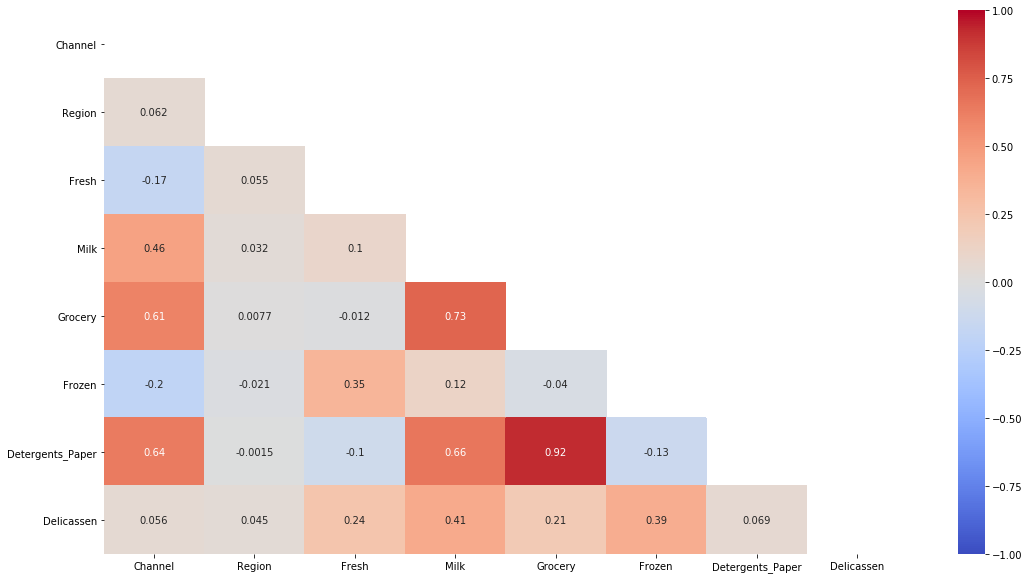

In [44]:
mask = np.triu(np.ones_like(customers.corr(), dtype=np.bool))
plt.figure(figsize=(18,10))
sns.heatmap(customers.corr(), mask=mask, cmap="coolwarm", annot=True, vmin=-1, vmax=1) 

plt.show()

In [45]:
customers.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [46]:
stats = customers.describe().T
stats["IQR"] = stats["75%"] - stats ["25%"]
outliers = pd.DataFrame(columns=customers.columns)
for col in stats.index:
    iqr = stats.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats.at[col,'25%'] - cutoff
    upper = stats.at[col,'75%'] + cutoff
    results = customers[(customers[col] < lower)].copy()
    results['Outlier'] = col
    outliers = outliers.append(results)
stats

,count,mean,std,min,25%,50%,75%,max,IQR
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0,1.00
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0,1.00
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0,13806.00
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0,5657.25
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0,8502.75
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0,2812.00
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0,3665.25
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0,1412.00


In [47]:
outliers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Outlier


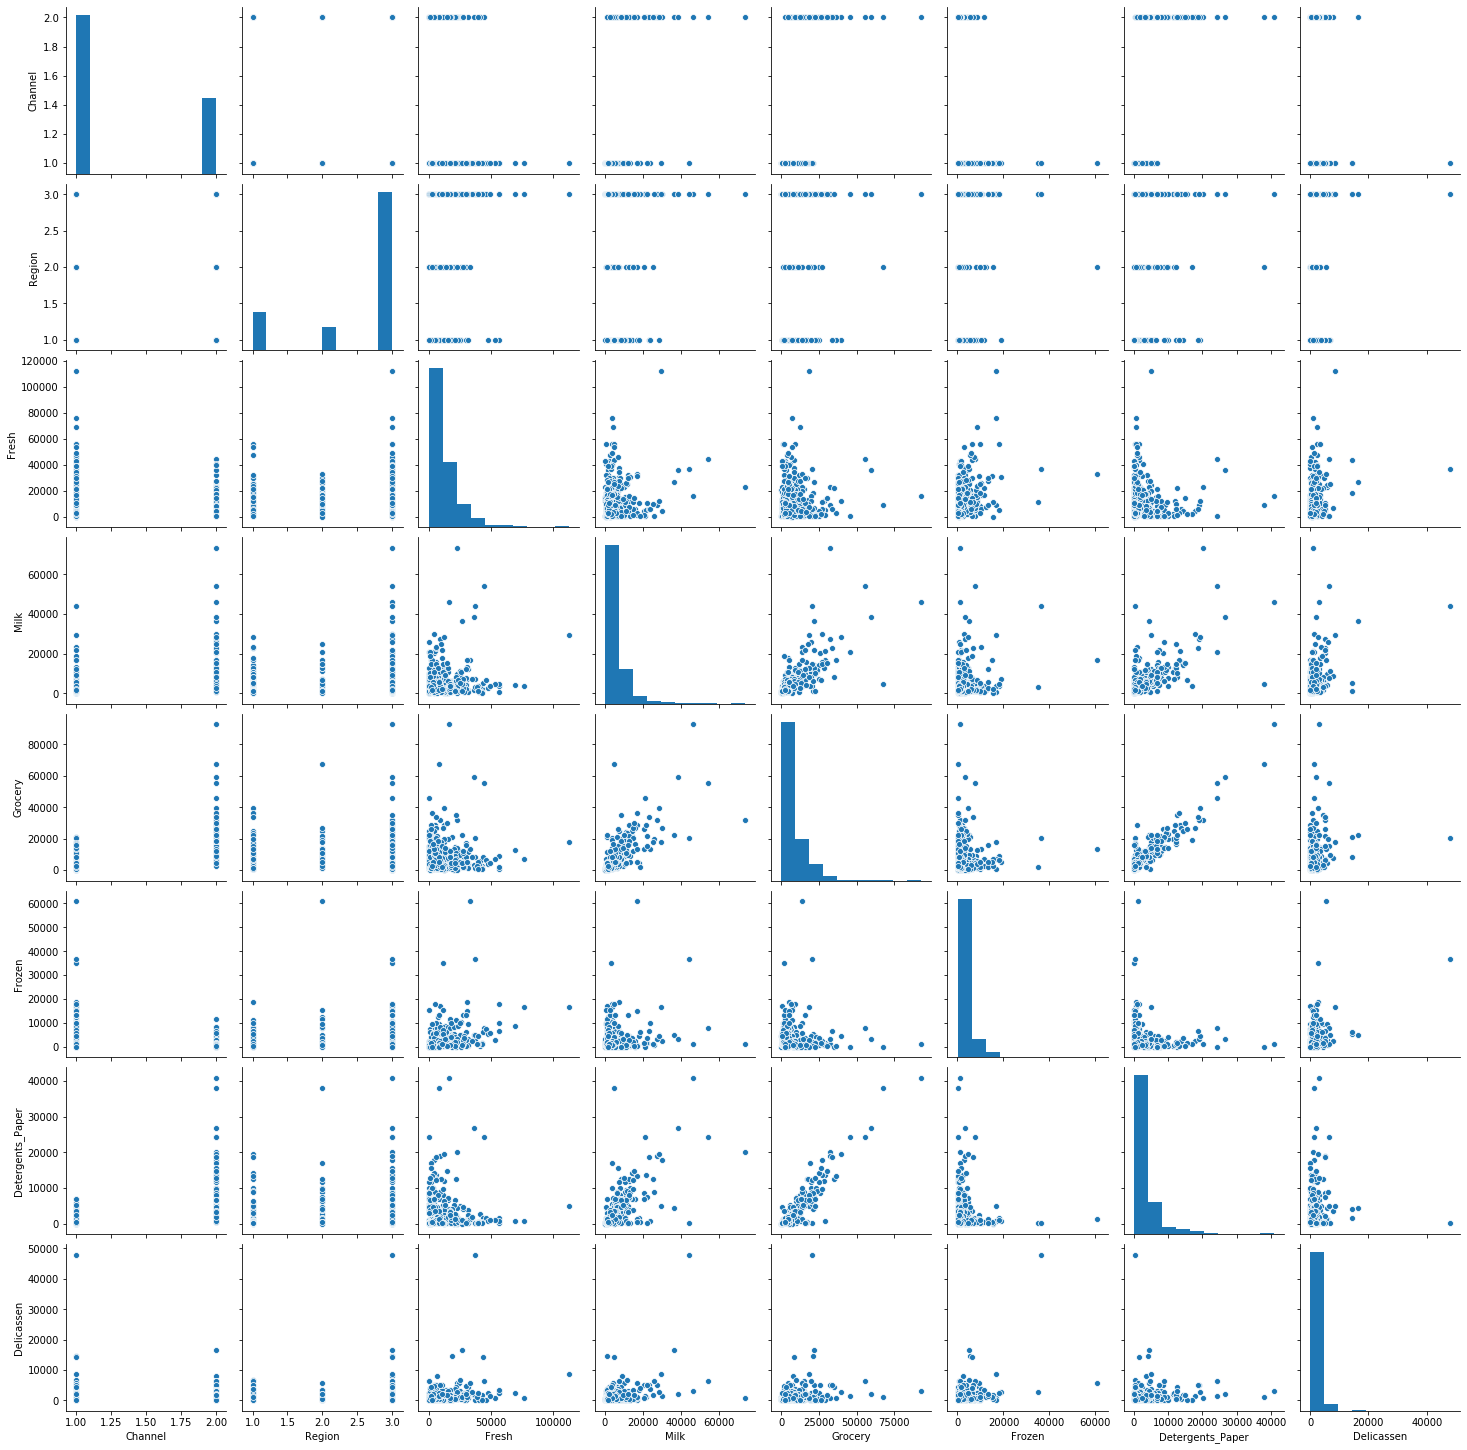

In [48]:
sns.pairplot(customers)

In [49]:
print("20% of most loyal customers count for",(customers.iloc[:,2:].sum(axis =1).sort_values(ascending=False)[:int(customers.shape[0]*0.2)].sum() * 100)/ customers.iloc[:,2:].sum(axis=1).sum(),"% of the customers account")

20% of most loyal customers count for 42.90483942679298 % of the customers account


### Your observations here

1) FRESH: annual spending (m.u.) on fresh products (Continuous);
2) MILK: annual spending (m.u.) on milk products (Continuous);
3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
7) CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
8) REGION: customers Region - Lisbon, Oporto or Other (Nominal)
 
No categorical data to convert
    
No missing or duplicated values
    
Pretty high collinearity between Grocery and Detergent_Paper
    
There is no outliers as the outliers dataframe created before ended up being empty
    
Continuous variables show a right-skewed distribution

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [50]:
customers.astype({"Channel": "object", "Region": "object"}).dtypes

Channel             object
Region              object
Fresh                int64
Milk                 int64
Grocery              int64
Frozen               int64
Detergents_Paper     int64
Delicassen           int64
dtype: object

I think there's no need to clean data but Channel and Region shouldn't be integers as those numbers are tags not real numeric values.

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [51]:
customers_scale = StandardScaler().fit_transform(customers[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]])

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [52]:
kmeans = KMeans().fit(customers_scale)
customers["labels"] = kmeans.labels_

Count the values in `labels`.

In [53]:
# Your code here:
customers["labels"].value_counts()

1    223
3     99
7     42
5     40
0     29
6      4
4      2
2      1
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [54]:
dbscan =  DBSCAN(eps=0.5).fit(customers_scale)
customers["labels_DBSCAN"] = dbscan.labels_

Count the values in `labels_DBSCAN`.

In [55]:
# Your code here
customers["labels_DBSCAN"].value_counts()

 0    261
-1    174
 1      5
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

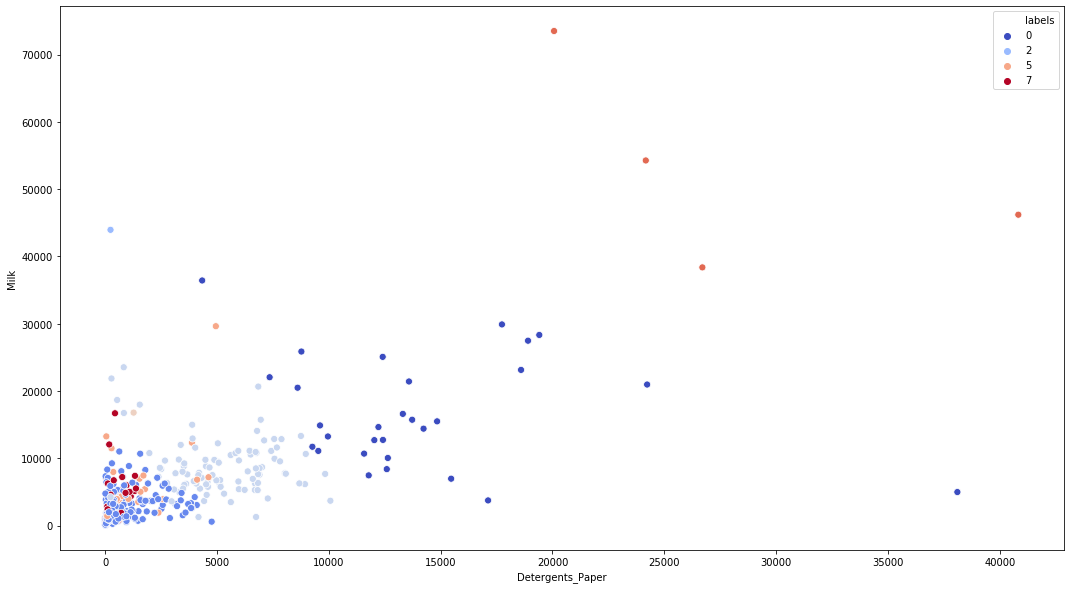

In [69]:
plt.figure(figsize=(18,10))
sns.scatterplot(data=customers, x="Detergents_Paper", y = "Milk", hue = "labels", palette ="coolwarm", s=50)
plt.show()

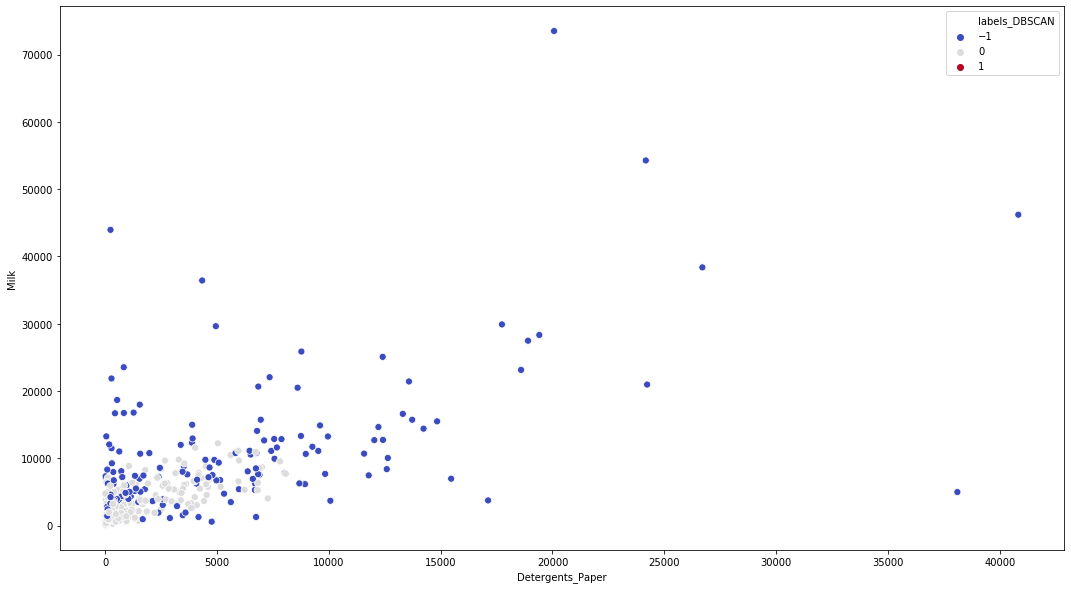

In [70]:
plt.figure(figsize=(18,10))
sns.scatterplot(data=customers, x="Detergents_Paper", y = "Milk", hue = "labels_DBSCAN", palette ="coolwarm", s=50)
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

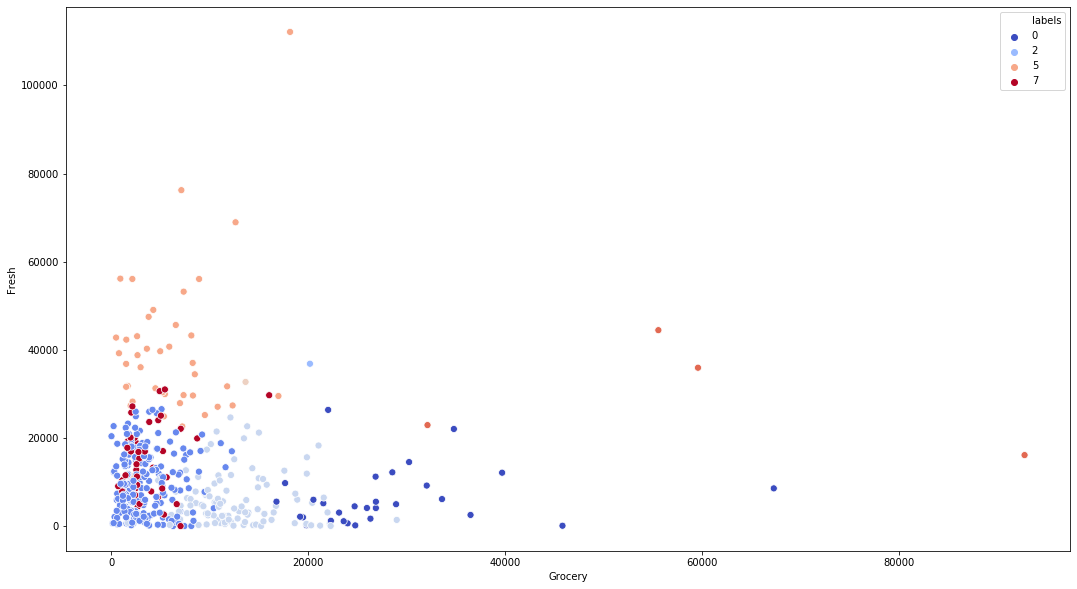

In [71]:
# Your code here:
plt.figure(figsize=(18,10))
sns.scatterplot(data=customers, x="Grocery", y = "Fresh", hue = "labels", palette ="coolwarm", s=50)
plt.show()

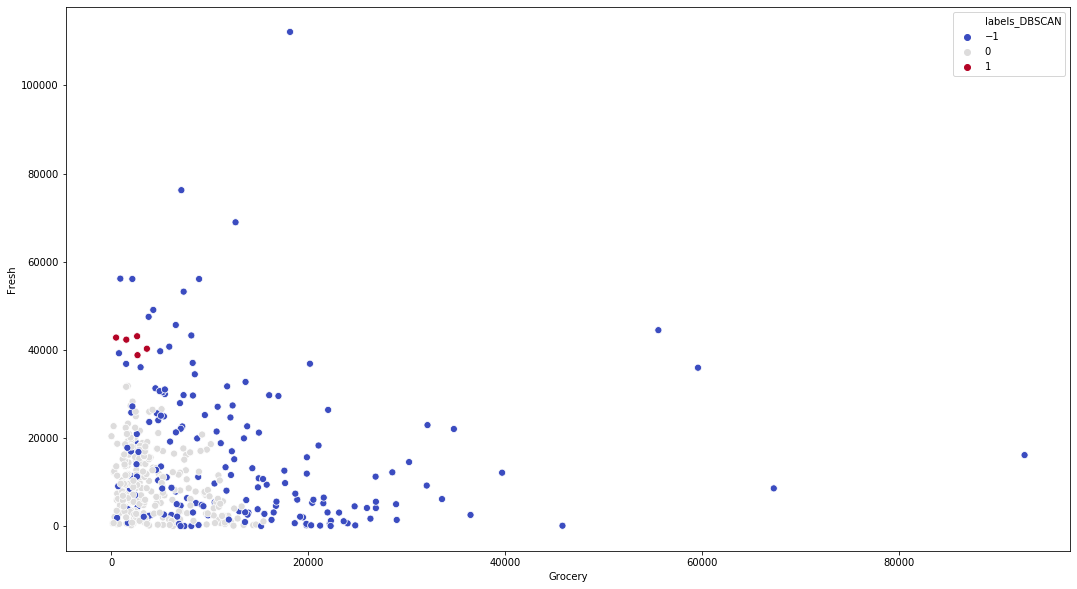

In [72]:
plt.figure(figsize=(18,10))
sns.scatterplot(data=customers, x="Grocery", y = "Fresh", hue = "labels_DBSCAN", palette ="coolwarm", s=50)
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

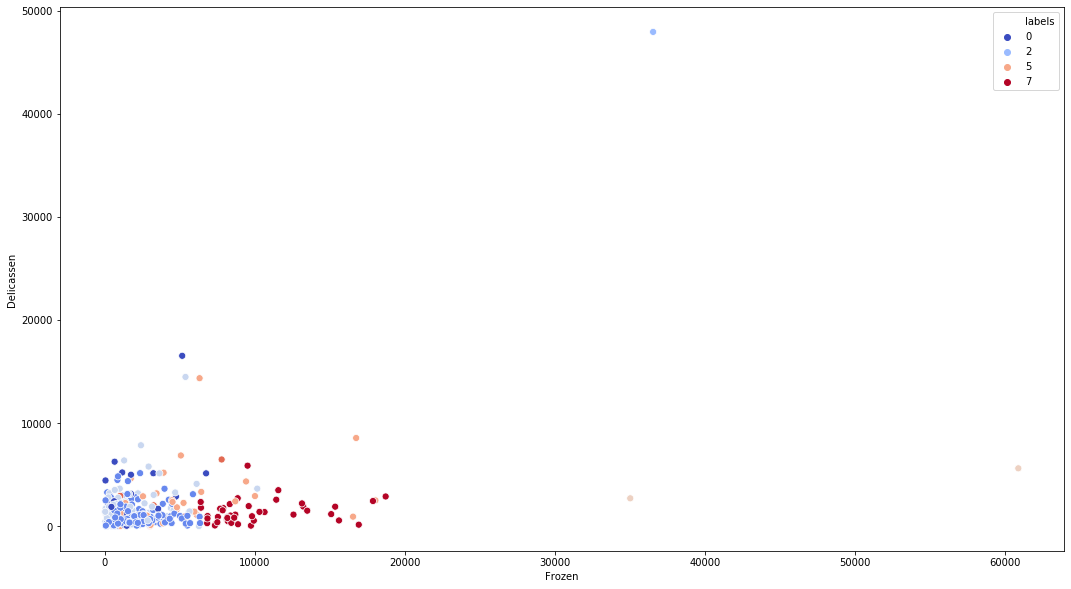

In [73]:
# Your code here:
plt.figure(figsize=(18,10))
sns.scatterplot(data=customers, x="Frozen", y = "Delicassen", hue = "labels", palette ="coolwarm", s=50)
plt.show()

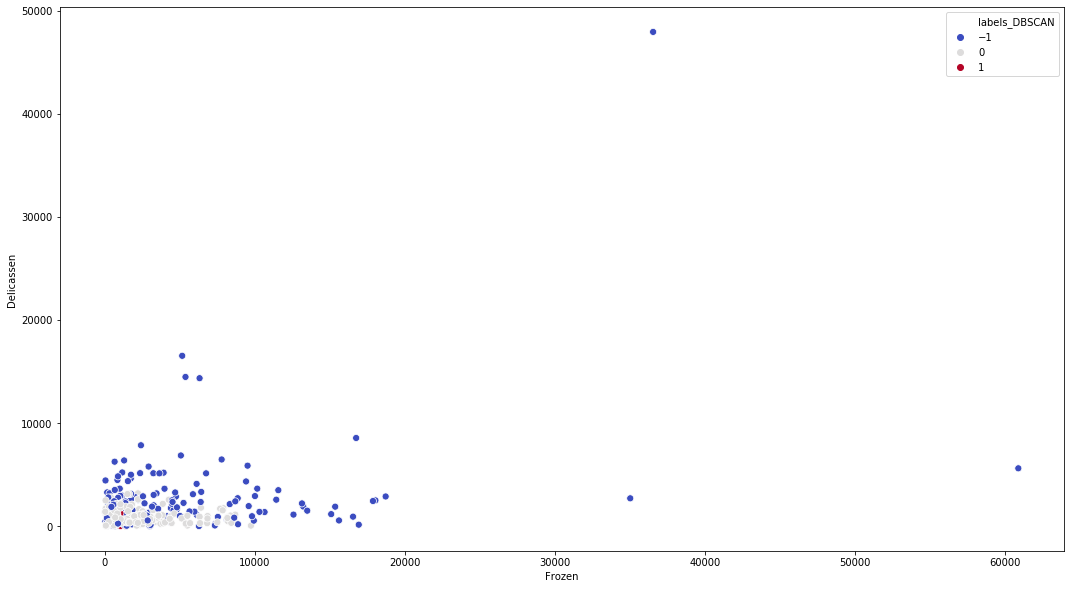

In [74]:
plt.figure(figsize=(18,10))
sns.scatterplot(data=customers, x="Frozen", y = "Delicassen", hue = "labels_DBSCAN", palette ="coolwarm", s=50)
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [75]:
# Your code here:
customers_kmeans = customers.groupby(["labels"])["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"].mean()
customers_kmeans

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
labels,,,,,,
0,6443.379310,16777.344828,27920.586207,1781.931034,13943.448276,2575.655172
1,9237.663677,2564.103139,3313.372197,1744.013453,795.183857,914.511211
2,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000
3,5950.101010,8759.767677,12811.232323,1605.191919,5135.696970,1707.858586
4,22015.500000,9937.000000,7844.000000,47939.000000,671.500000,4153.500000
5,40546.450000,4875.200000,6053.925000,4625.800000,1092.975000,2406.500000
6,29862.500000,53080.750000,60015.750000,3262.250000,27942.250000,3082.250000
7,14810.190476,3658.261905,3895.071429,10039.333333,492.071429,1390.380952


In [76]:
customers_dbscan = customers.groupby(["labels_DBSCAN"])["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"].mean()
customers_dbscan

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
labels_DBSCAN,,,,,,
-1,15608.988506,10000.408046,13693.298851,4786.275862,5291.373563,2510.781609
0,9030.398467,3077.318008,4234.061303,1963.432950,1322.134100,881.773946
1,41446.600000,1421.200000,2167.600000,1276.400000,416.200000,784.800000


Which algorithm appears to perform better?

Based on the graphs and the metrics I'd say DBSCAN performs better

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here